# Build out Bayesian Model on Texas Data

In [2]:
#! conda install -c conda-forge "pymc>=5"

In [4]:
pip install corner

Note: you may need to restart the kernel to use updated packages.


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [67]:
import pymc as pm
import corner
import arviz as az

In [6]:
from scipy.optimize import minimize

### Import the Data
Bring in the data from the pickle file. At the start, we're limiting this to grounded data.

In [7]:
data = pd.read_pickle('snr_paper_data.pickle')

In [8]:
full_df = data['all_data'].loc[(~np.isnan(data['all_data']['snr'])) & 
                               (~np.isnan(data['all_data']['thickness'])) &
                               (~np.isnan(data['all_data']['surf_temp'])) &
                               (~np.isnan(data['all_data']['base_temp'])) &
                               (~np.isnan(data['all_data']['v'])) &
                               (~np.isnan(data['all_data']['atten']))
                              ]

In [11]:
variable_df = full_df[['snr', 'thickness', 'surf_temp', 
                    'base_temp', 'mask', 'x','y', 'v']]

In [12]:
variable_df['log_v'] = np.log(variable_df['v'])

/srv/conda/envs/notebook/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_141/2886050638.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  variable_df['log_v'] = np.log(variable_df['v'])


In [13]:
model_df = variable_df[~np.isinf(variable_df['log_v'])]

In [14]:
grounded_df = model_df.loc[model_df['mask']==2]

In [15]:
len(grounded_df)

15823

In [16]:
grounded_df.columns

Index(['snr', 'thickness', 'surf_temp', 'base_temp', 'mask', 'x', 'y', 'v',
       'log_v'],
      dtype='object')

### Norm the Columns of Interest

For now, we'll start with thickness and surface temp (see pairplotting.py for visualization of how much variability is captured by each option)

In [41]:
thickness = grounded_df['thickness']
surf_temp = grounded_df['surf_temp']
snr = grounded_df['snr']

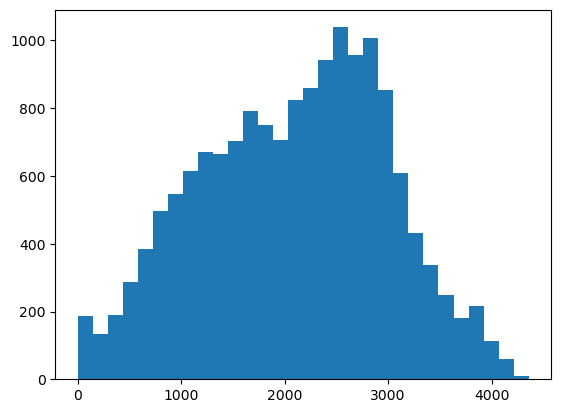

In [21]:
plt.hist(thickness, bins=30);

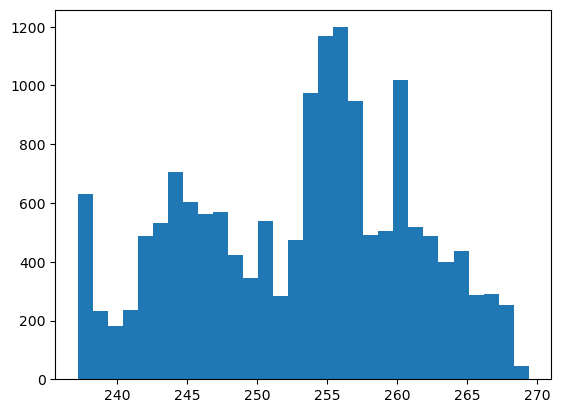

In [22]:
plt.hist(surf_temp, bins=30);

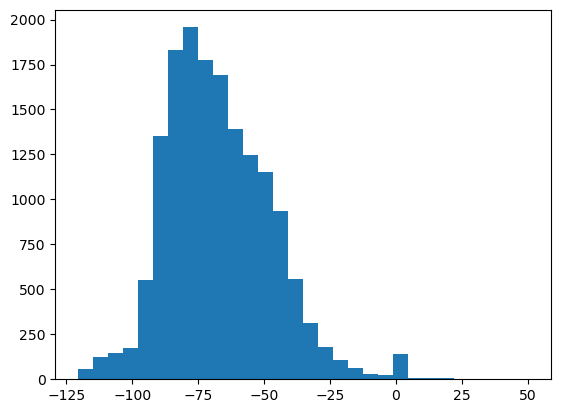

In [42]:
plt.hist(snr, bins=30);

Both of these have heavy tails, so we'll use robust scalar.

In [30]:
def combo_scaler(x, range_max=2):
    median_x = np.median(x)
    iqr_x = np.percentile(x,75) - np.percentile(x,25)
    robust_x = ((x-median_x)/iqr_x)

    return (((robust_x - np.nanmin(robust_x)) / (np.nanmax(robust_x) - np.nanmin(robust_x))) * range_max)-1

In [46]:
norm_thickness = combo_scaler(thickness)

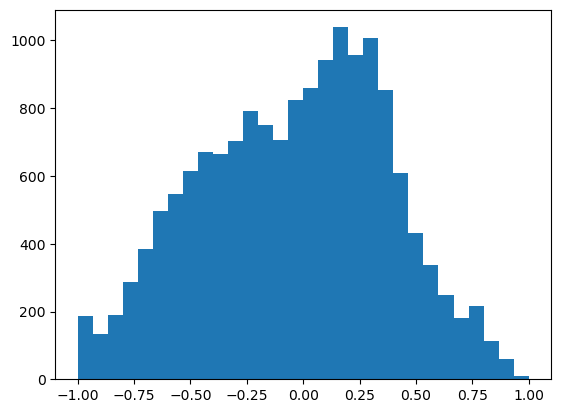

In [47]:
plt.hist(norm_thickness, bins=30);

In [48]:
norm_surf_temp = combo_scaler(surf_temp)

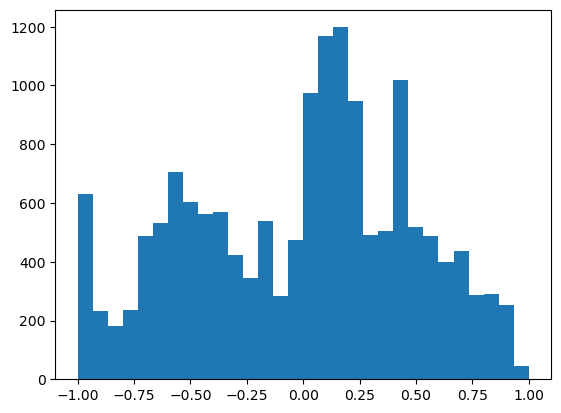

In [49]:
plt.hist(norm_surf_temp, bins=30);

In [50]:
norm_snr = combo_scaler(snr)

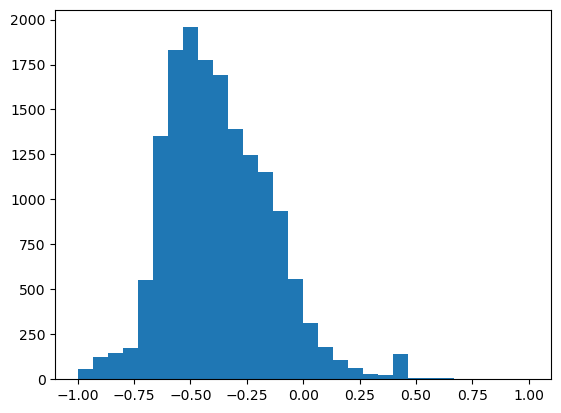

In [51]:
plt.hist(norm_snr, bins=30);

I've combo scaled them to preserve the underlying distribution of the data while keeping the distributions bounded around zero. NOTE! The distribution of snr clearly has a strong outlier, and might benefit from just robust scaling, and having it's long positive tail hang over 1. Can check how this affects outcomes.

### Find the initial likelihood

For now, I'm writing this without measurement uncertainty, but I will fold this in as soon as we have uncertainties. (Note to self: look back at my regression notebook for notes on how to do this properly.)

In [56]:
np.random.seed(42)

def ln_like(theta, thickness_obs, surf_temp_obs, snr_sim):
    beta_0, beta_thickness, beta_surf_temp = theta
    model = beta_0 * np.exp(beta_thickness*thickness_obs +
                            beta_surf_temp*surf_temp_obs
                           )
    
    # uncertainties = np.sqrt(xerr**2 + yerr**2)
    # ln_z = -0.5 * np.sum(((z_obs - model) / uncertainties)**2 + np.log(2*np.pi) + np.log(uncertainties))

    ln_z = -0.5 * np.sum((snr_sim - model)**2 + np.log(2*np.pi))
    
    return ln_z

In [57]:
nll = lambda *args: -ln_like(*args)
initial = np.repeat(0.0,3) + 0.1 * np.random.randn(3)
likelihood = minimize(nll, initial, 
                      args=(norm_thickness, norm_surf_temp, norm_snr), 
                      method='BFGS')
beta_0_ml, beta_thickness_ml, beta_surf_temp_ml = likelihood.x

In [76]:
with pm.Model() as texas_model:

    # Define weakly informative Normal priors for Ridge regression
    sigma = pm.HalfNormal("sigma", 1) #recommended for StudentT
    b0 = pm.Normal("intercept", beta_0_ml, sigma=10)
    b1 = pm.Normal("beta_thickness", beta_thickness_ml, sigma=10)
    b2 = pm.Normal("beta_surface_temp", beta_surf_temp_ml, sigma=10)
    # b_EX = pm.Normal("name", 0, sigma=0.1) #heavily regularizing prior, might be useful for colinear situations ahead
    

    # Define linear model
    y_est = b0 + b1*norm_thickness + b2*norm_surf_temp

    # Define prior for StudentT degrees of freedom
    # Inverse Gamma is recommended
    nu = pm.InverseGamma("nu", alpha=1, beta=1)

    # Define Student T likelihood, because of the presence of outliers
    likelihood = pm.StudentT(
        "likelihood", mu=y_est, sigma=sigma, nu=nu, observed=norm_snr
    )
    
    texas_trace = pm.sample(10000, cores=3,
                           target_accept=0.8)#,
                           # return_inferencedata=False)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [sigma, intercept, beta_thickness, beta_surface_temp, nu]


Output()

Sampling 3 chains for 1_000 tune and 10_000 draw iterations (3_000 + 30_000 draws total) took 94 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Now that this has finished running, let's investigate convergence.

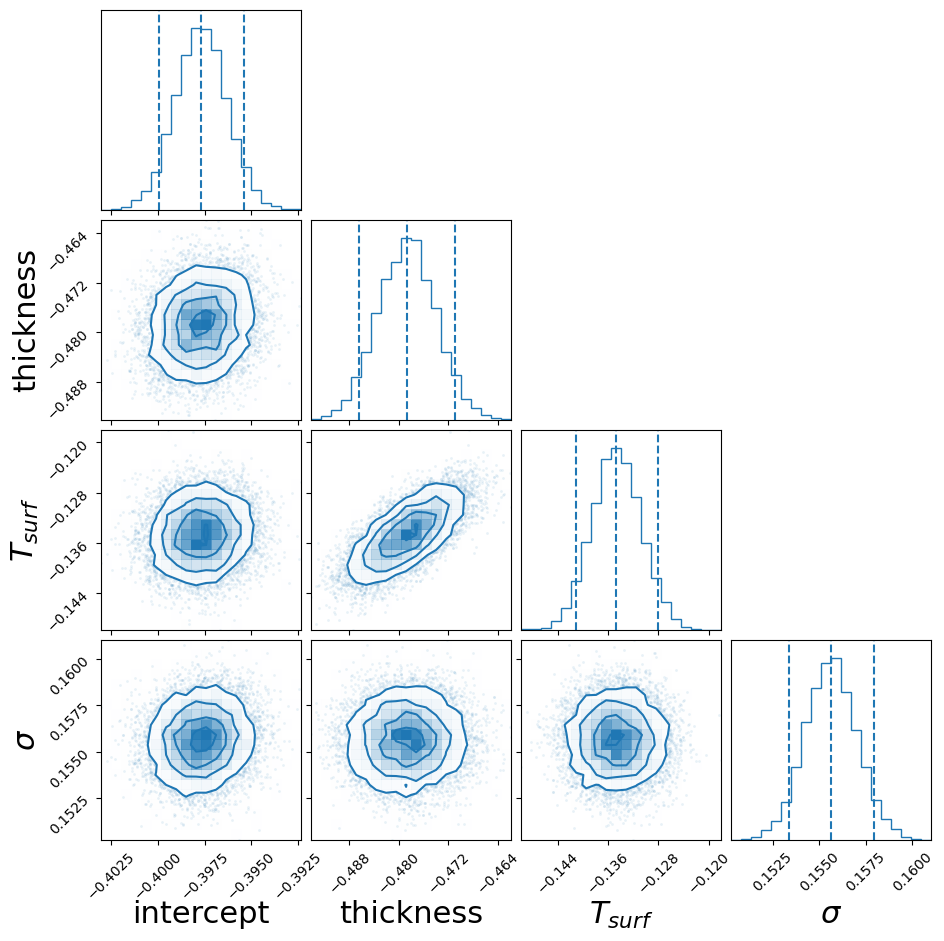

In [66]:
fig = corner.corner(np.vstack((texas_trace.get_values('intercept', chains=0),
                               texas_trace.get_values('beta_thickness', chains=0), 
                               texas_trace.get_values('beta_surface_temp', chains=0),
                               texas_trace.get_values('sigma', chains=0))).T, 
                    labels = ['intercept', 'thickness', 
                              '$T_{surf}$',
                              '$\sigma$'], color='#1f77b4',
                    alpha=0.25, 
                    label_kwargs={"fontsize": 22, "labelpad": 5}, 
                    quantiles=[0.05, 0.5, 0.95])

# corner.corner(np.vstack((texas_trace.get_values('intercept', chains=1),
#                          texas_trace.get_values('beta_thickness', chains=1), 
#                          texas_trace.get_values('beta_surface_temp', chains=1),
#                          texas_trace.get_values('sigma', chains=1))).T,
#               color='#ff7f0e', alpha=0.25,
#               quantiles=[0.05, 0.5, 0.95])

# corner.corner(np.vstack((texas_trace.get_values('intercept', chains=2),
#                          texas_trace.get_values('beta_thickness', chains=2), 
#                          texas_trace.get_values('beta_surface_temp', chains=2),
#                          texas_trace.get_values('sigma', chains=2))).T,
#               color='#2ca02c', alpha=0.25,
#               quantiles=[0.05, 0.5, 0.95])

Let's look more closely at these coefficients:

In [77]:
az.summary(texas_trace, hdi_prob = 0.68, round_to=3).loc[['intercept', 'beta_thickness', 
                                                          'beta_surface_temp', 'sigma'], :]

,mean,sd,hdi_16%,hdi_84%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,-0.398,0.001,-0.399,-0.396,0.0,0.0,25892.364,20749.347,1.0
beta_thickness,-0.479,0.005,-0.484,-0.474,0.0,0.0,24152.443,21037.689,1.0
beta_surface_temp,-0.135,0.004,-0.139,-0.131,0.0,0.0,23572.298,21381.778,1.0
sigma,0.156,0.001,0.154,0.157,0.0,0.0,24063.142,22340.153,1.0


array([[<Axes: title={'center': 'intercept'}>,
        <Axes: title={'center': 'intercept'}>],
       [<Axes: title={'center': 'beta_thickness'}>,
        <Axes: title={'center': 'beta_thickness'}>],
       [<Axes: title={'center': 'beta_surface_temp'}>,
        <Axes: title={'center': 'beta_surface_temp'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

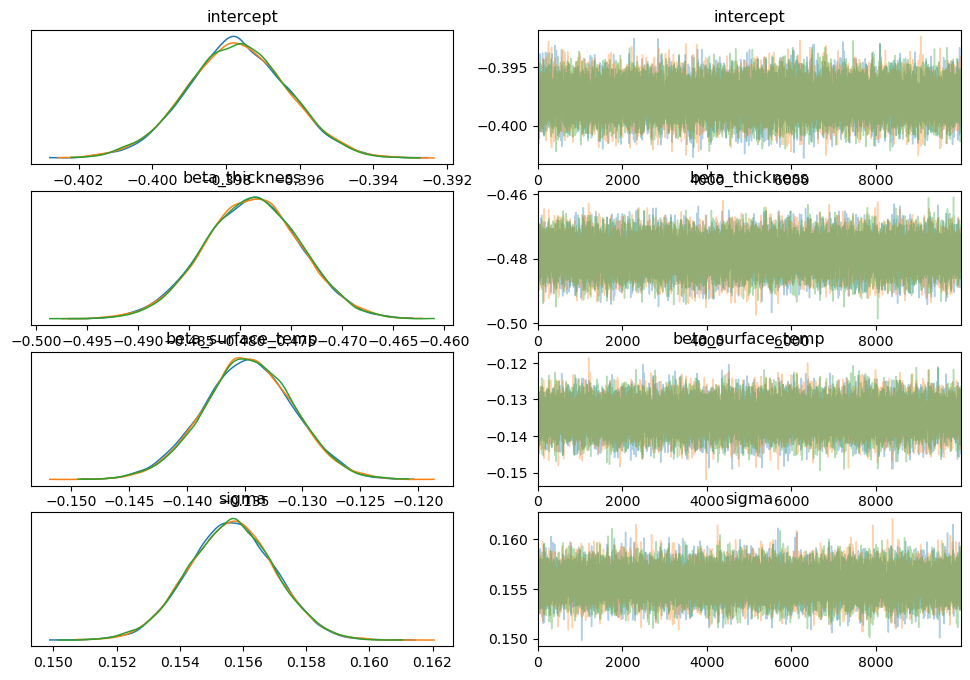

In [78]:
az.plot_trace(texas_trace, 
              var_names=['intercept', 'beta_thickness', 
                         'beta_surface_temp', 'sigma'], 
              combined=False, compact=False)